# Transfer Learning using the YAMNet pre-trained model

YAMNet is an audio event classifier that takes audio waveform as input and makes independent predictions for each of 521 audio events from the AudioSet ontology. The model uses the MobileNet v1 architecture and was trained using the AudioSet corpus.

# Colab dependencies

In [ ]:
#https://www.tensorflow.org/lite/tutorials/model_maker_audio_classification

In [ ]:
! pip install tflite-model-maker

In [ ]:
# Google Drive connection

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [3]:
import tensorflow as tf
import tflite_model_maker as mm
from tflite_model_maker import audio_classifier
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import glob
import random

from IPython.display import Audio, Image
from scipy.io import wavfile

print(f"TensorFlow Version: {tf.__version__}")
print(f"Model Maker Version: {mm.__version__}")

TensorFlow Version: 2.7.0
Model Maker Version: 0.3.4


In [4]:
# Util functions and data structures

data_dir = '/content/drive/MyDrive/Capstone_Project - Audio Analysis/Capstone_Proj/YAMNet_model_dataset'

code_to_name = {
  'helo': 'Helicopter',
  'fixed': 'Fixed-wing'   
}

birds_images = {
  'helo': 'https://en.wikipedia.org/wiki/Helicopter#/media/File:LAPD_Bell_206_Jetranger.jpg',
  'fixed': 'https://en.wikipedia.org/wiki/Cessna_172#/media/File:Cessna_172S_Skyhawk_SP,_Private_JP6817606.jpg'
}

test_files = os.path.abspath(os.path.join(data_dir, 'test/*/*.wav'))

def get_random_audio_file():
  test_list = glob.glob(test_files)
  random_audio_path = random.choice(test_list)
  return random_audio_path


def show_bird_data(audio_path):
  sample_rate, audio_data = wavfile.read(audio_path, 'rb')

  bird_code = audio_path.split('/')[-2]
  print(f'Bird name: {code_to_name[bird_code]}')
  print(f'Bird code: {bird_code}')
  display(Image(birds_images[bird_code]))

  plttitle = f'{code_to_name[bird_code]} ({bird_code})'
  plt.title(plttitle)
  plt.plot(audio_data)
  display(Audio(audio_data, rate=sample_rate))

print('functions and data structures created')



functions and data structures created


In [ ]:
random_audio = get_random_audio_file()

show_bird_data(random_audio)

In [6]:
spec = audio_classifier.YamNetSpec(
    keep_yamnet_and_custom_heads=True,
    frame_step=1 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH,
    frame_length=15 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH)

INFO:tensorflow:Checkpoints are stored in /tmp/tmpr5c264m1


In [7]:
train_data = audio_classifier.DataLoader.from_folder(
    spec, os.path.join(data_dir, 'train'), cache=True)
train_data, validation_data = train_data.split(0.8)
test_data = audio_classifier.DataLoader.from_folder(
    spec, os.path.join(data_dir, 'test'), cache=True)

In [11]:
%%time
batch_size = 128
epochs = 100

print('Training the model')
model = audio_classifier.create(
    train_data,
    spec,
    validation_data,
    batch_size=batch_size,
    epochs=epochs)

Training the model
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 classification_head (Dense)  (None, 2)                2050      
                                                                 
Total params: 2,050
Trainable params: 2,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3/3 [==============================] - 189s 21s/step - loss: 0.5882 - acc: 0.6899 - val_loss: 0.5565 - val_acc: 0.7722
Epoch 2/100
3/3 [==============================] - 0s 185ms/step - loss: 0.5552 - acc: 0.7184 - val_loss: 0.5271 - val_acc: 0.7848
Epoch 3/100
3/3 [==============================] - 0s 187ms/step - loss: 0.5182 - acc: 0.7785 - val_loss: 0.5018 - val_acc: 0.8101
Epoch 4/100
3/3 [==============================] - 0s 190ms/step - loss: 0.4765 - acc: 0.8354 - val_loss: 0.4799 - val_acc: 0.8101
Epoch 5/100
3/3 [====================

In [9]:
print('Evaluating the model')
model.evaluate(test_data)

Evaluating the model
1/1 [==============================] - 16s 16s/step - loss: 0.3310 - acc: 0.9091


[0.3309602439403534, 0.9090909361839294]

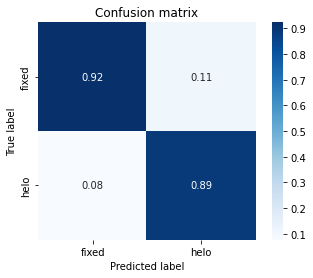

In [10]:
def show_confusion_matrix(confusion, test_labels):
  """Compute confusion matrix and normalize."""
  confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
  axis_labels = test_labels
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.2f', square=True)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

confusion_matrix = model.confusion_matrix(test_data)
show_confusion_matrix(confusion_matrix.numpy(), test_data.index_to_label)